## Predict

Important!
1. Make sure 1-Train.ipynb is completed to get the dependencies and model (should take no more than 30min to train on a standard 3080 GPU)
2. For test data, best to get same resolution (1920x1080) and scale (10m) imagery from google earth as there are no augmentation on training

In [ ]:
# Setup up model and path
from detectree2.models.train import setup_cfg

trained_model = "train_outputs/model_11.pth"
cfg = setup_cfg(update_model=trained_model) # update_model arg can be used to load in trained  model

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from detectree2.preprocessing.tiling import tile_data

# sample test data (outside from test and train set)
site_path = "sample_data"
img_path = site_path + "/random_oilpalm.tif"
tiles_path = site_path + "/tilespred_map15/"

# Read in the tiff file
data = rasterio.open(img_path)
fig, ax = plt.subplots(1, figsize=(10, 8))
image_hidden = ax.imshow(data.read(1), cmap='viridis') # Create a hidden image to map the colorbar
show(data.read(1), ax=ax, cmap='viridis')
fig.colorbar(image_hidden, ax=ax) # Add the colorbar using the hidden image
plt.show()
data.close()

# We using the same tile parameters as in the training
buffer = 10
tile_width = 15
tile_height = 15
tile_data(img_path, tiles_path, buffer, tile_width, tile_height, dtype_bool = True)

In [ ]:
from detectree2.models.predict import predict_on_data
from detectron2.engine import DefaultPredictor
from detectree2.models.outputs import project_to_geojson
from detectree2.models.outputs import stitch_crowns, clean_crowns

#cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)

predict_on_data(
    directory=tiles_path,          # First parameter: directory with the tiles
    out_folder="predictions/", # Second parameter: output folder name
    predictor=predictor            # Third parameter: the predictor object
)
project_to_geojson(tiles_path, tiles_path + "predictions/", tiles_path + "predictions_geo/")
folder = tiles_path+ "/predictions_geo"
crowns = stitch_crowns(folder, 1)
crowns = crowns[crowns.is_valid]
# Simplify crowns to help with editing 
crowns = crowns.set_geometry(crowns.simplify(0.3))
crowns
crowns = clean_crowns(crowns, confidence=0.4)
crowns.to_file(site_path + "/predicted_crowns_map15.gpkg")

## Visualize

Number of crowns: 96


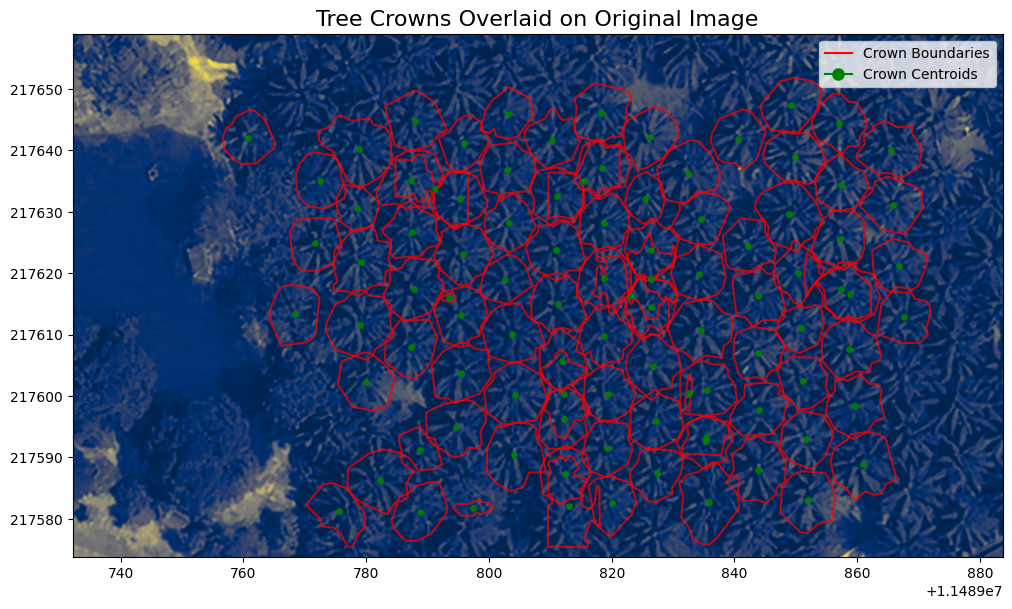

In [1]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import mapping

# Paths
site_path = "sample_data/"
img_path = site_path + "random_oilpalm.tif"
crowns_path = site_path + "predicted_crowns_map15.gpkg"

# Load the crown polygons
crowns = gpd.read_file(crowns_path)

# Open the original raster image
with rasterio.open(img_path) as src:
    image = src.read()  # Read all bands
    transform = src.transform
    crs = src.crs
    
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot the image
    # If the image has 3 bands (RGB), display it as a color image
    if image.shape[0] == 3:
        # Normalize each band for better visualization
        rgb = np.zeros((image.shape[1], image.shape[2], 3))
        for i in range(3):
            band = image[i]
            band_min, band_max = np.percentile(band[band > 0], (2, 98))
            rgb[:, :, i] = np.clip((band - band_min) / (band_max - band_min), 0, 1)
        show(rgb, ax=ax, transform=transform)
    else: 
        # If it's a single band or more than 3 bands, display the first band
        show(image[0], ax=ax, cmap='cividis', transform=transform)
    
    # Make sure crowns has the same CRS as the raster
    if crowns.crs != crs:
        crowns = crowns.to_crs(crs)
    
    # Plot the crowns with a semi-transparent fill and bold outline
    crowns.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1.5, alpha=0.7)
    
    # Add centroids for reference
    centroids = crowns.copy()
    centroids['geometry'] = centroids.geometry.centroid
    print(f'Number of crowns: {len(centroids)}')
    centroids.plot(ax=ax, color='green', markersize=15, alpha=0.9)
    
    # Add a title and labels
    plt.title('Tree Crowns Overlaid on Original Image', fontsize=16)
    
    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', lw=1.5, label='Crown Boundaries'),
        Line2D([0], [0], marker='o', color='green', markerfacecolor='green', 
               markersize=8, label='Crown Centroids')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Save the figure
    plt.savefig(site_path + "/crowns_overlay.png", dpi=300, bbox_inches='tight')
    plt.show()

# Optional: Create a mask from the crowns
def create_crown_mask(raster_path, crowns_gdf, output_path):
    """Create a binary mask raster from crown polygons"""
    with rasterio.open(raster_path) as src:
        # Create a blank raster with the same dimensions
        mask = np.zeros((src.height, src.width), dtype=np.uint8)
        
        # Make sure crowns has the same CRS as the raster
        if crowns_gdf.crs != src.crs:
            crowns_gdf = crowns_gdf.to_crs(src.crs)
        
        # Rasterize the crowns
        from rasterio.features import rasterize
        shapes = [(mapping(geom), 1) for geom in crowns_gdf.geometry]
        mask = rasterize(shapes, out_shape=(src.height, src.width), 
                         transform=src.transform, fill=0, default_value=1)
        
        # Create a new raster file with the mask
        profile = src.profile.copy()
        profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
        
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(mask, 1)
    
    return output_path